In [1]:
import sys, os; sys.path.insert(0, os.path.abspath('..'))
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')
import logging
logging.getLogger().setLevel(logging.CRITICAL)

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression

from src.utils import (get_data, features, target, cv_splits_no_val, partial_days, full_days, weekends, split_dataset_by_dates, optimize_model_with_custom_splits, 
evaluate_and_visualize_model, get_index_for_days, get_cv_days)
from src.pipeline import get_pipeline, CustomTimeSeriesSplitter
from src.plotting import plot_param_importances

In [2]:
df, df_test, df_training, df_test_2 = get_data()

In [3]:
to_remove = ['Index', 'num', 'Occupancy', 'Light_pct_change']
features = [x for x in df.columns if x not in to_remove]

In [4]:
X_train, y_train, X_val, y_val, _, _ = split_dataset_by_dates(df, features, target, train_dates=partial_days[:-1]+weekends[:-1]+full_days[:-2], 
                                                                        test_dates=full_days[-2:]+weekends[-1:]+partial_days[-1:])

In [5]:
all_cv_days = get_cv_days(cv_splits_no_val)
df_cv = df.iloc[get_index_for_days(df.index, all_cv_days)].copy()

cv_splitter = CustomTimeSeriesSplitter(cv_splits_no_val, df_cv.index)

In [6]:
linear_pipeline = get_pipeline(model=LogisticRegression)

linear_params = {
    'model__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear', 'saga'],
    'model__class_weight': ['balanced'],
    'model__max_iter': [4000],
    'model__random_state': [42],
    'historic_feature__add_feature': [True, False],
    'historic_feature__period_length': [5, 15, 30, 60],
    'feature_selector__feature_selection': [features, ['HumidityRatio', 'Light', 'CO2'], ['HumidityRatio', 'Light']] # None means take all features
}



In [7]:
best_linear_pipeline, linear_cv_results, best_linear_params, best_linear_score = optimize_model_with_custom_splits(df_cv, 
                                features, target, cv_splitter, linear_pipeline, linear_params, n_iter=10, n_jobs=-1,
                                  scoring='f1', random_state=42)

Best parameters: {'model__solver': 'liblinear', 'model__random_state': 42, 'model__penalty': 'l2', 'model__max_iter': 4000, 'model__class_weight': 'balanced', 'model__C': 100.0, 'historic_feature__period_length': 5, 'historic_feature__add_feature': False, 'feature_selector__feature_selection': ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio', 'Temperature_lag_1min', 'Temperature_lag_5min', 'Temperature_lag_10min', 'Temperature_change', 'Temperature_rolling_mean_15min', 'Temperature_rolling_mean_10min', 'Temperature_rolling_mean_5min', 'Temperature_rolling_std_15min', 'Temperature_rolling_std_10min', 'Temperature_rolling_std_5min', 'Temperature_rolling_change_mean_15min', 'Temperature_rolling_change_mean_10min', 'Temperature_rolling_change_mean_5min', 'Temperature_rolling_change_std_15min', 'Temperature_rolling_change_std_10min', 'Temperature_rolling_change_std_5min', 'Temperature_pct_change', 'Temperature_roc_5min', 'Humidity_lag_1min', 'Humidity_lag_5min', 'Humidity_lag_10m

input features: Index(['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio',
       'Temperature_lag_1min', 'Temperature_lag_5min', 'Temperature_lag_10min',
       'Temperature_change', 'Temperature_rolling_mean_15min',
       'Temperature_rolling_mean_10min', 'Temperature_rolling_mean_5min',
       'Temperature_rolling_std_15min', 'Temperature_rolling_std_10min',
       'Temperature_rolling_std_5min', 'Temperature_rolling_change_mean_15min',
       'Temperature_rolling_change_mean_10min',
       'Temperature_rolling_change_mean_5min',
       'Temperature_rolling_change_std_15min',
       'Temperature_rolling_change_std_10min',
       'Temperature_rolling_change_std_5min', 'Temperature_pct_change',
       'Temperature_roc_5min', 'Humidity_lag_1min', 'Humidity_lag_5min',
       'Humidity_lag_10min', 'Humidity_change', 'Humidity_rolling_mean_15min',
       'Humidity_rolling_mean_10min', 'Humidity_rolling_mean_5min',
       'Humidity_rolling_std_15min', 'Humidity_rolling_std_10min',

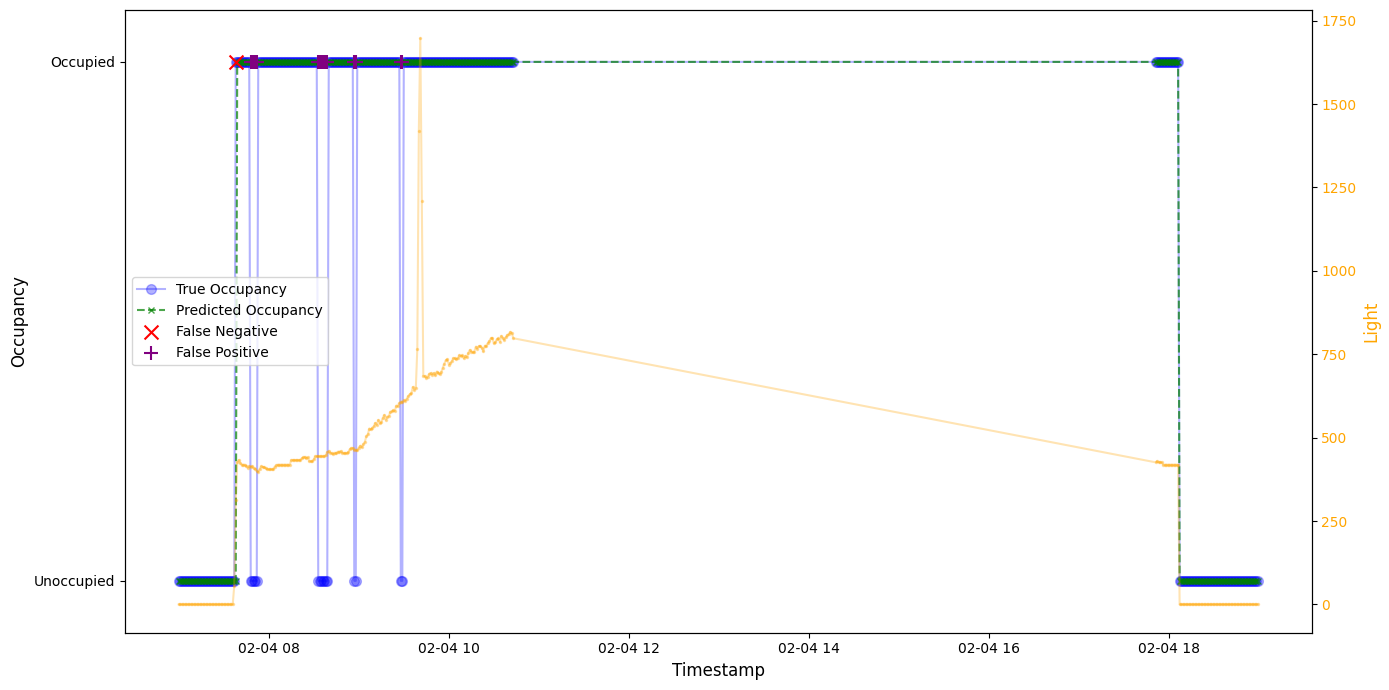

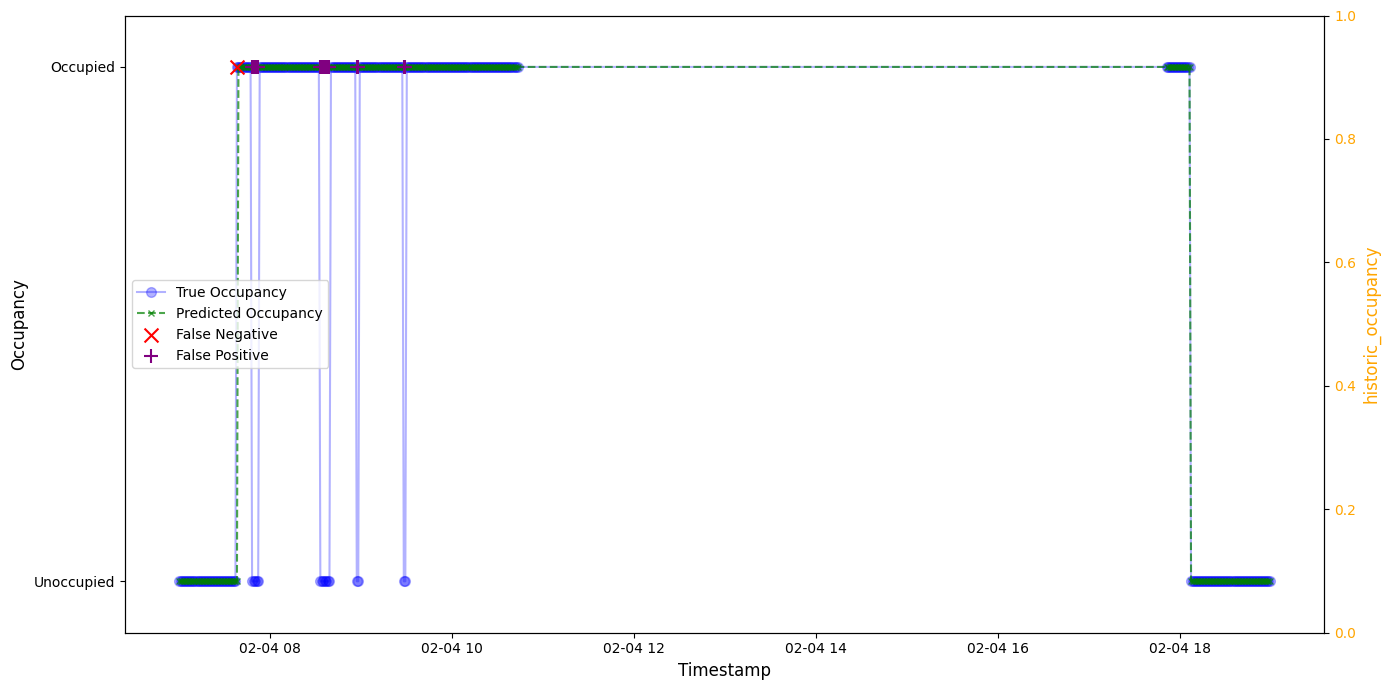

Date: 2015-02-06 / Day (07–19), Friday: 18 errors out of 720 records (2.50%)


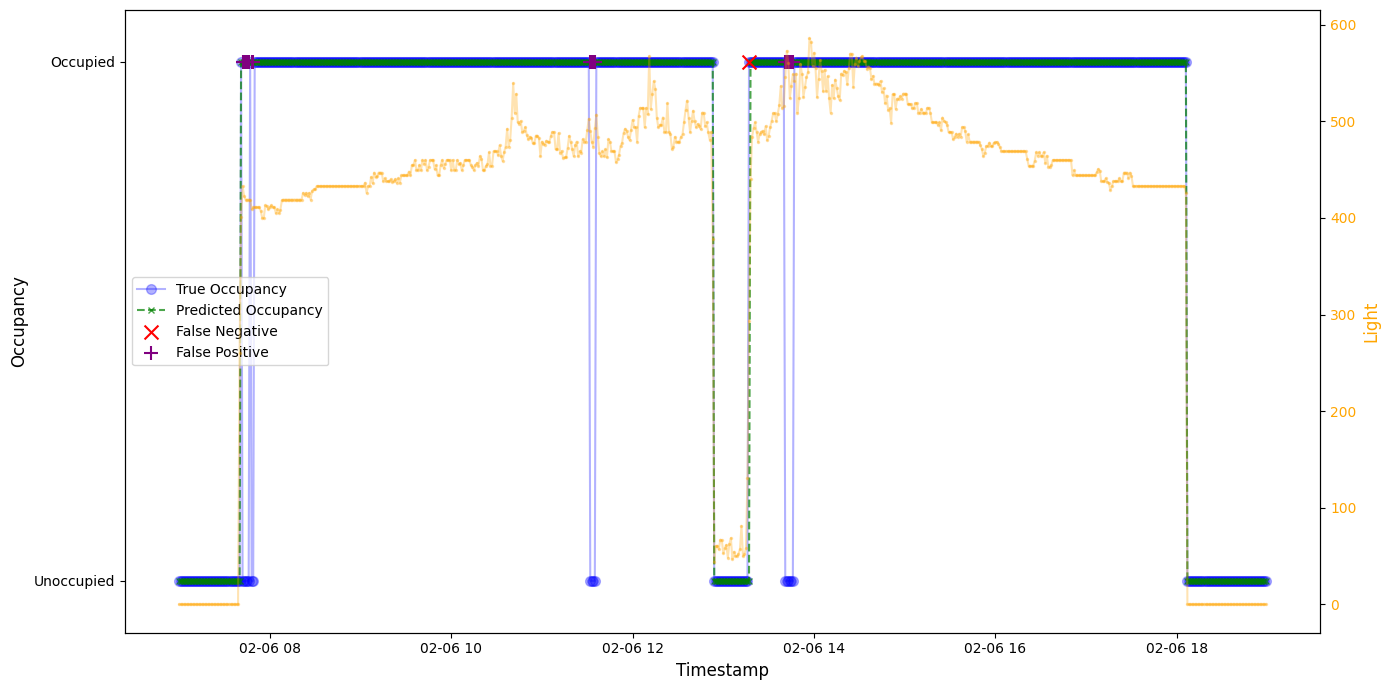

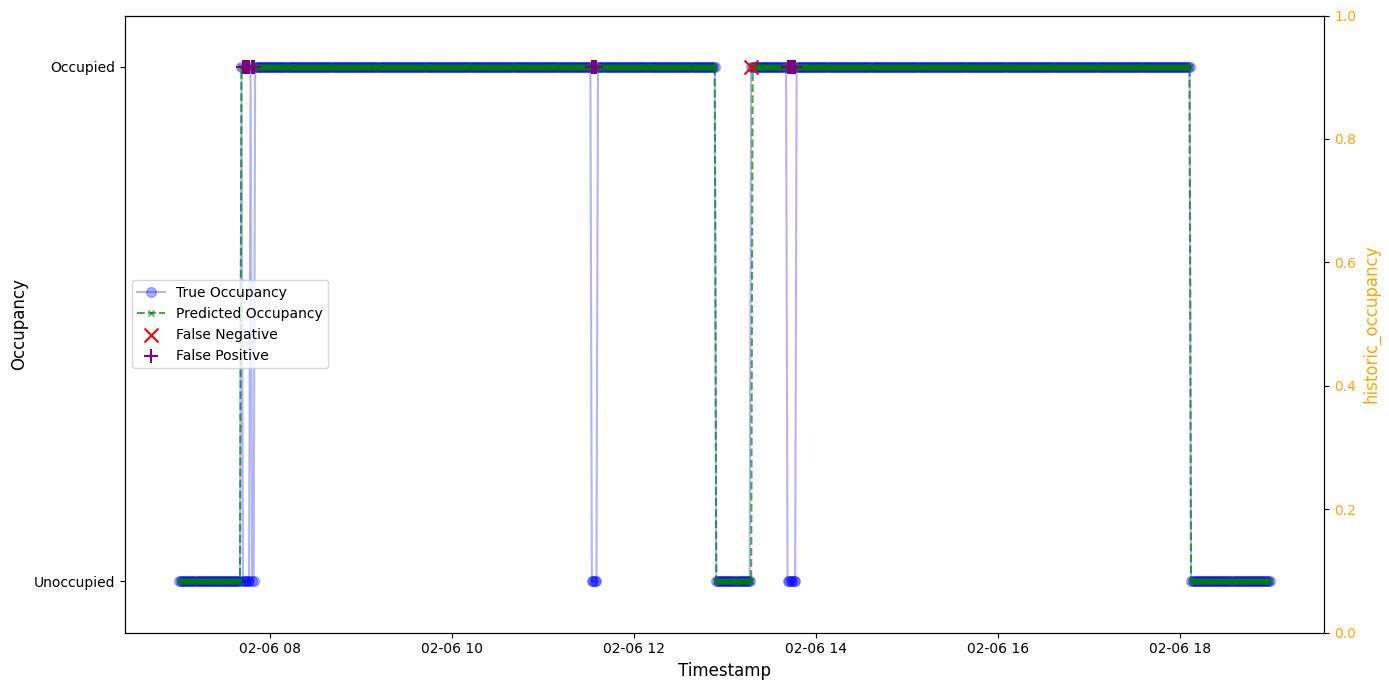

Date: 2015-02-07 / Day (07–19), Saturday: 3 errors out of 720 records (0.42%)


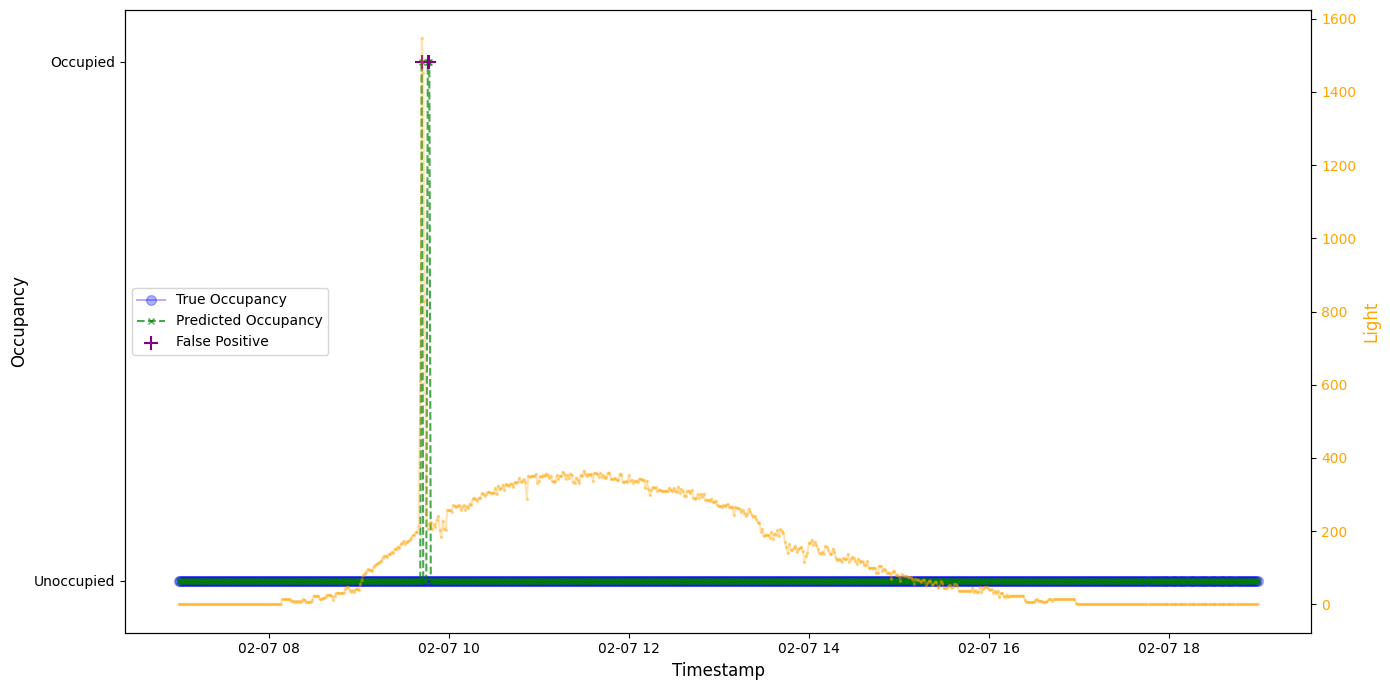

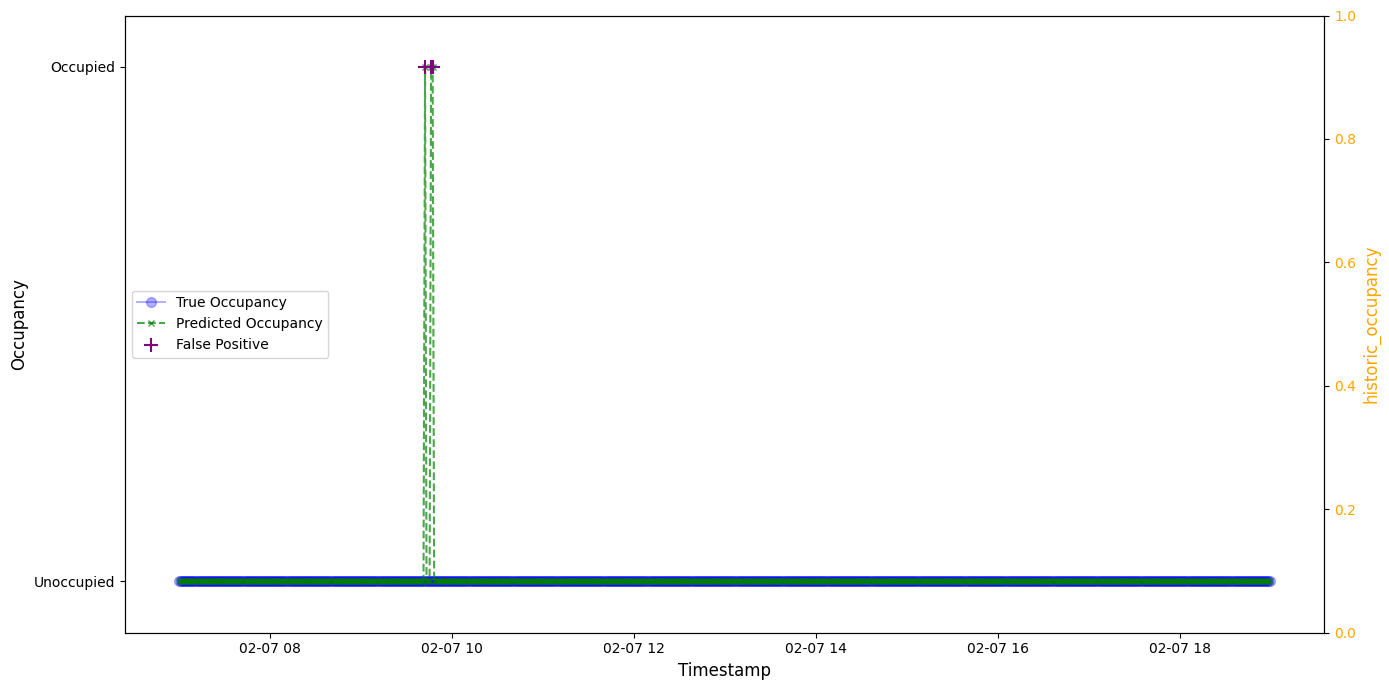

Date: 2015-02-09 / Day (07–19), Monday: 4 errors out of 720 records (0.56%)


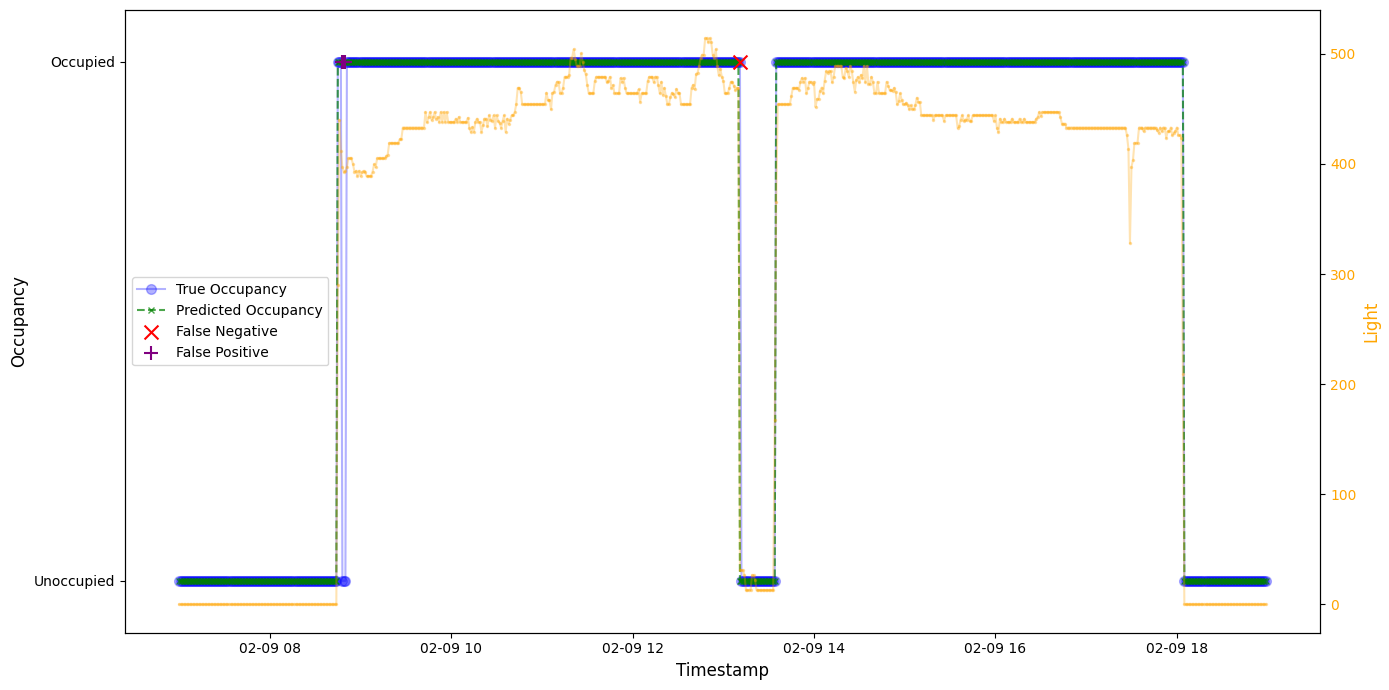

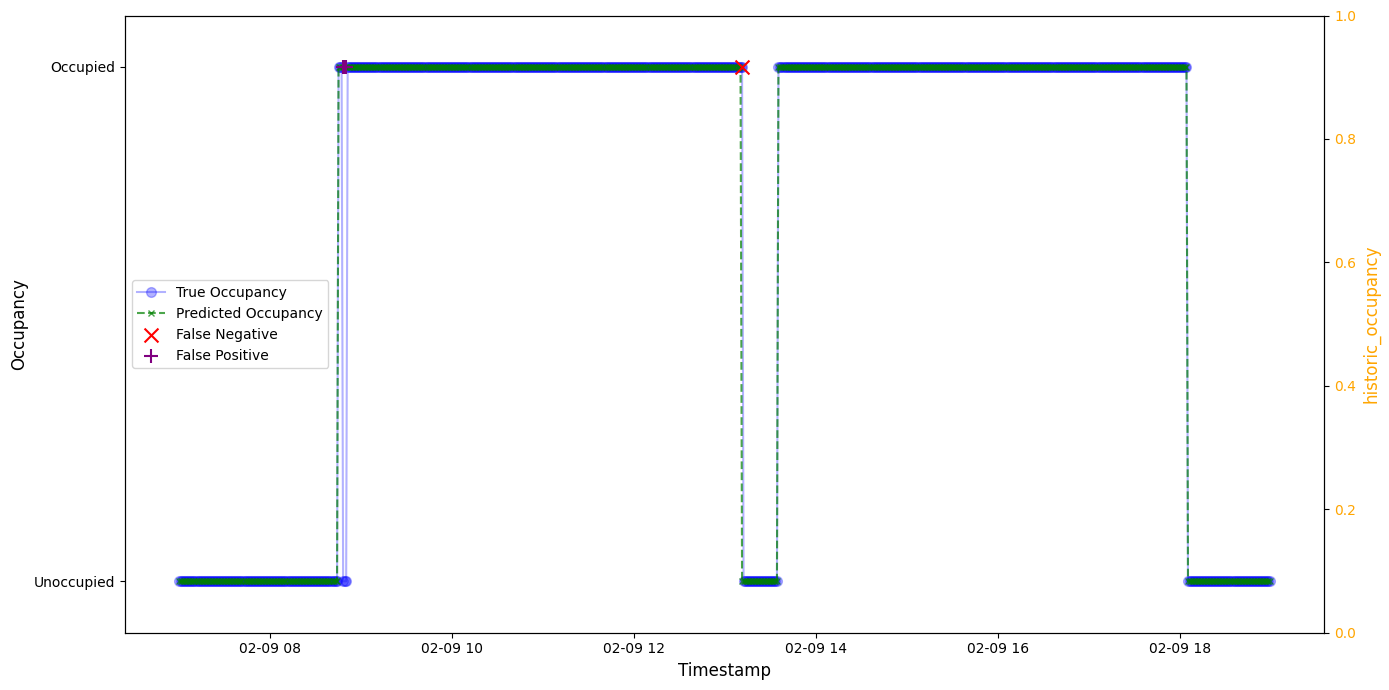

Date: 2015-02-10 / Day (07–19), Tuesday: 3 errors out of 154 records (1.95%)


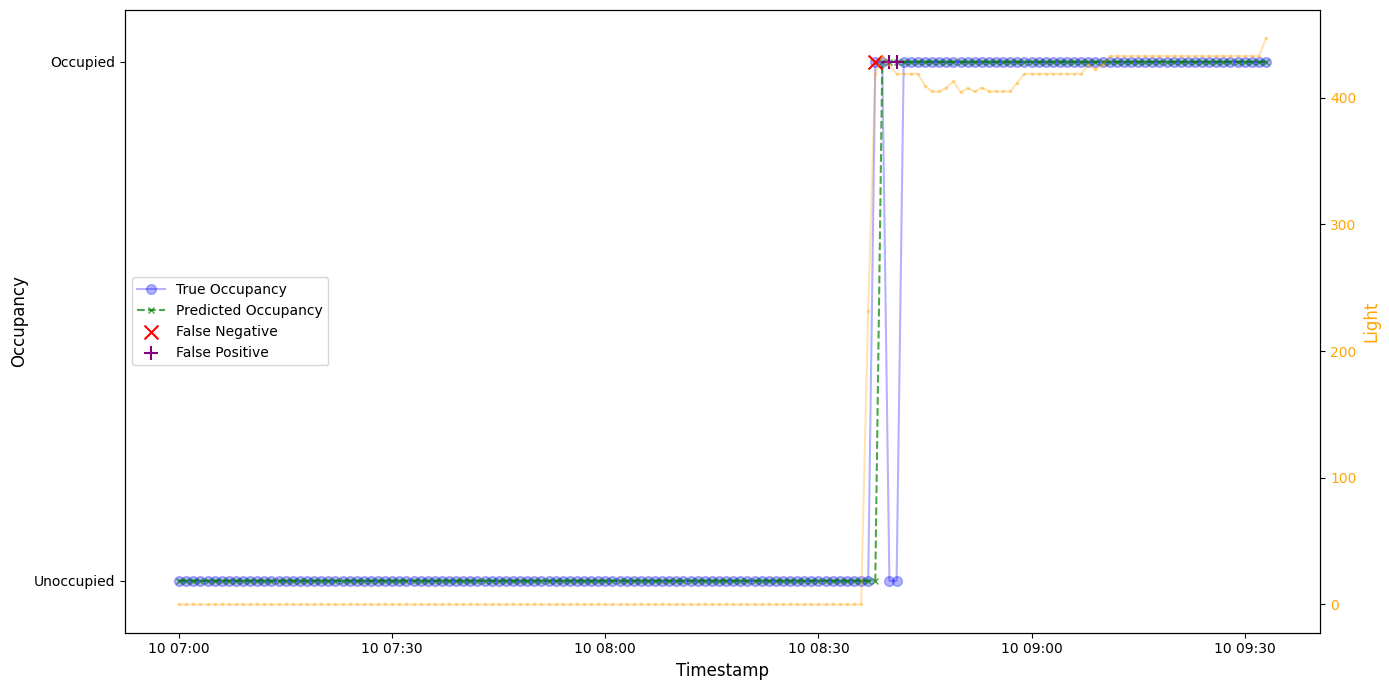

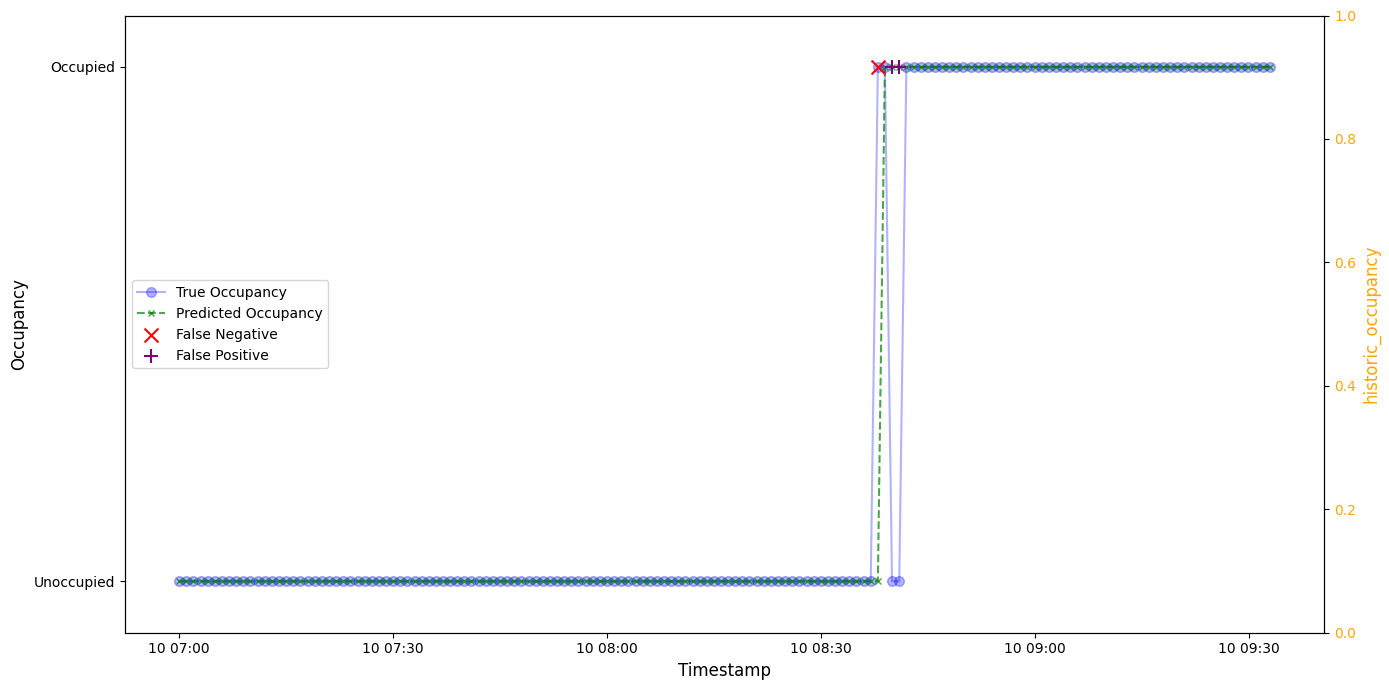

Date: 2015-02-11 / Day (07–19), Wednesday: 3 errors out of 252 records (1.19%)


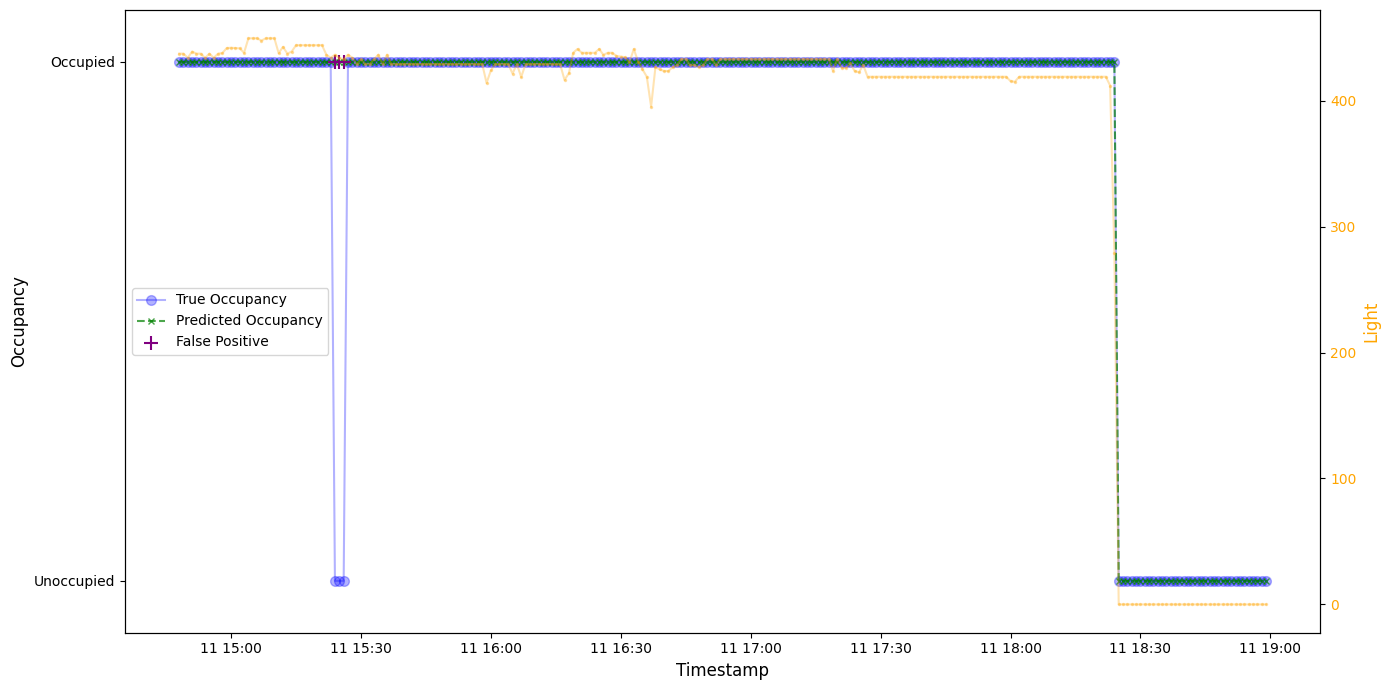

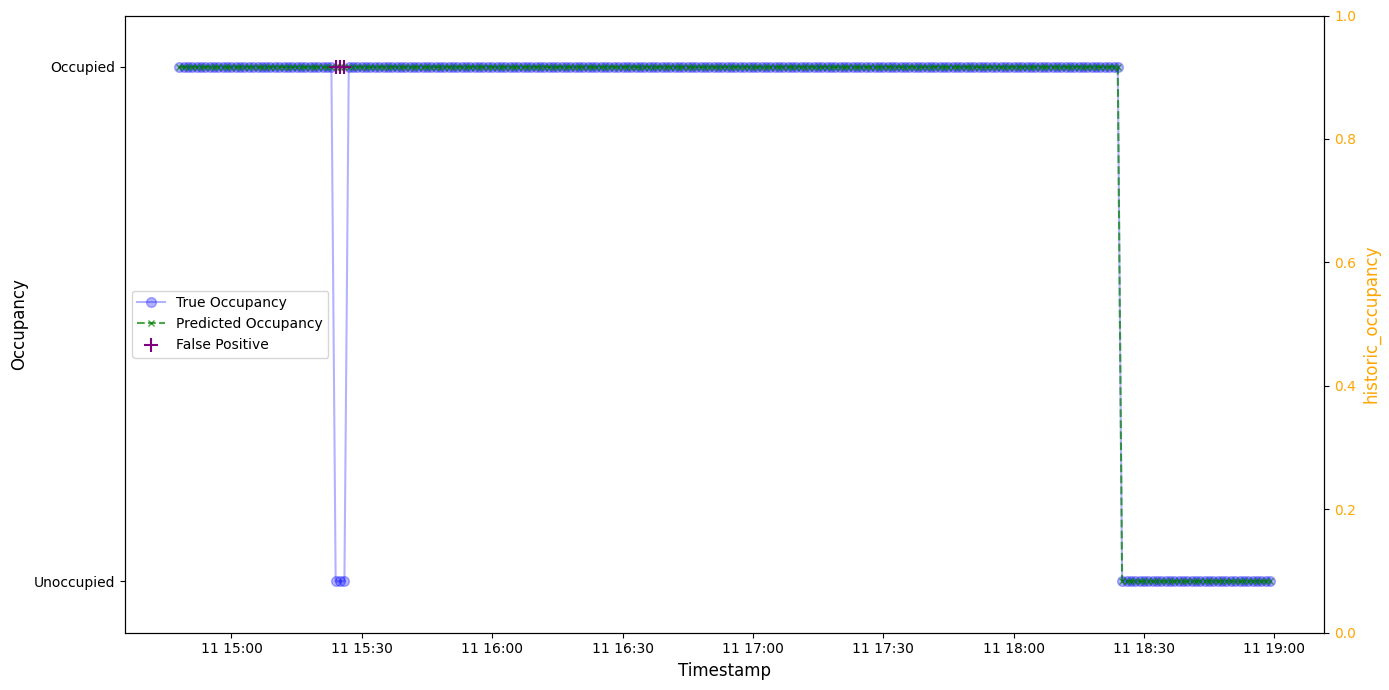

Date: 2015-02-12 / Day (07–19), Thursday: 11 errors out of 720 records (1.53%)


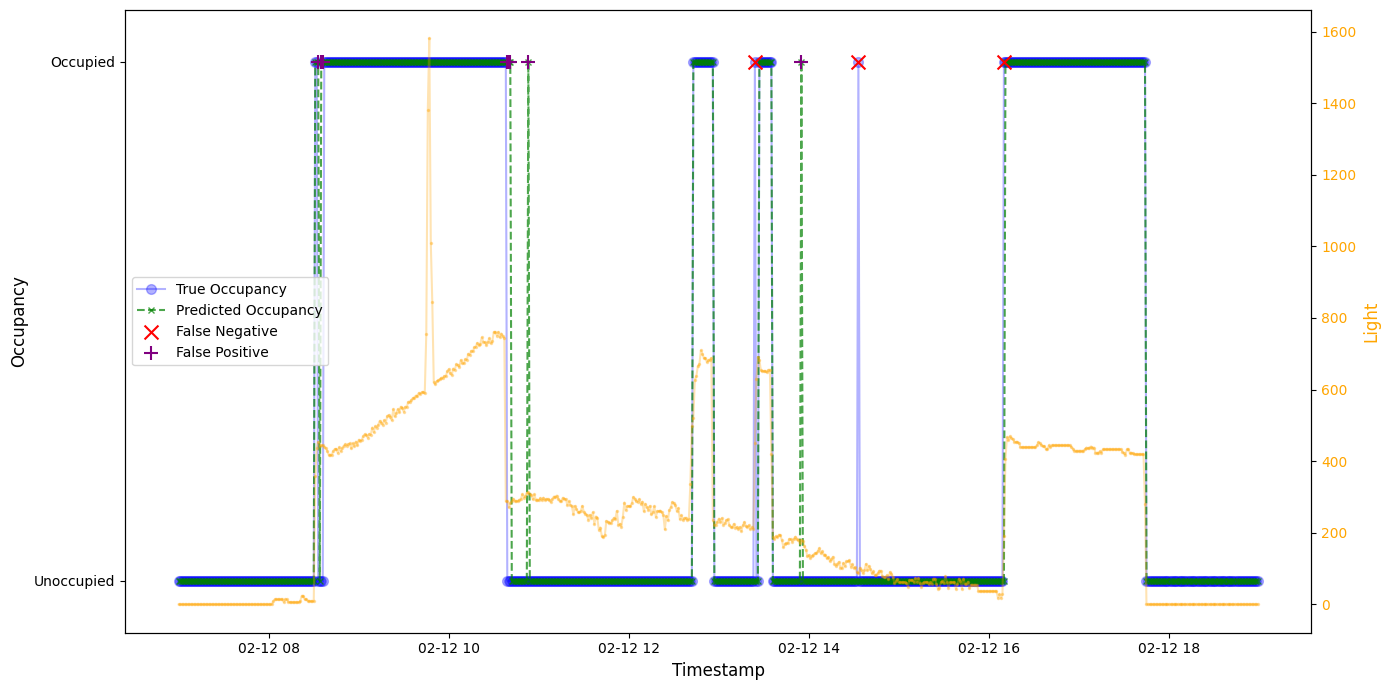

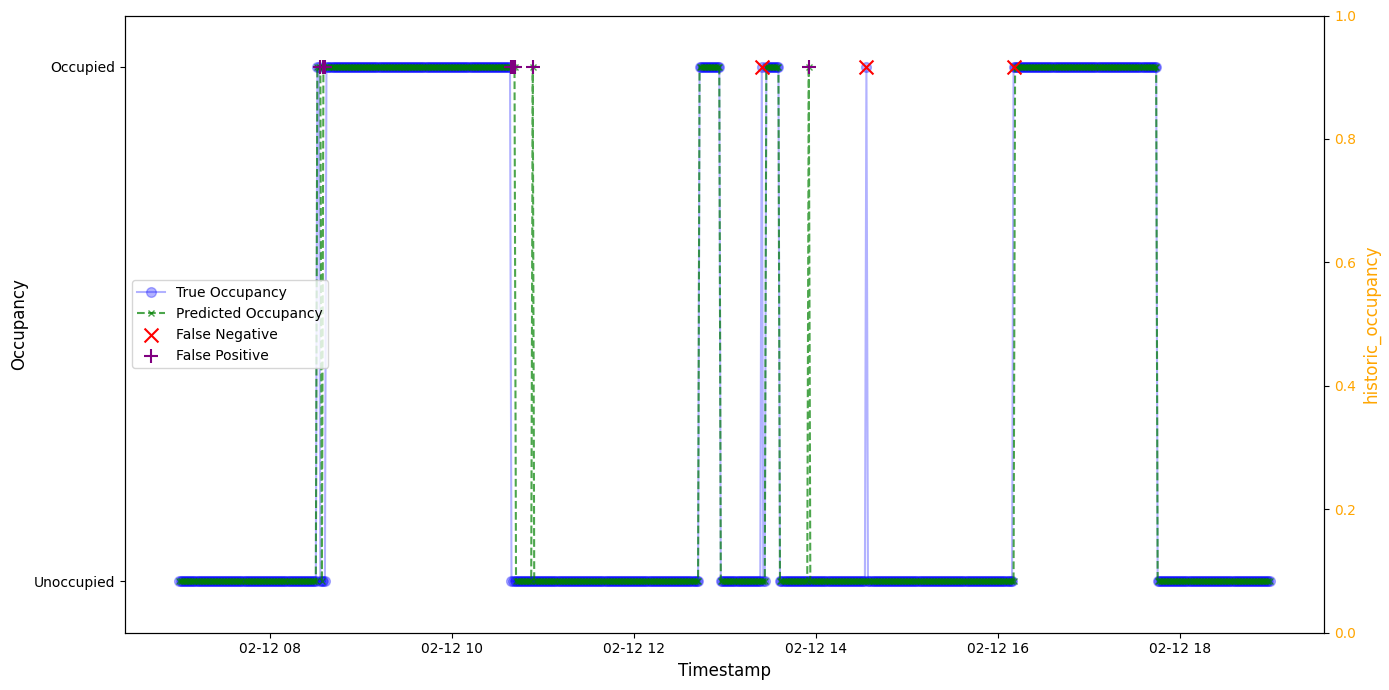

Date: 2015-02-13 / Day (07–19), Friday: 19 errors out of 720 records (2.64%)


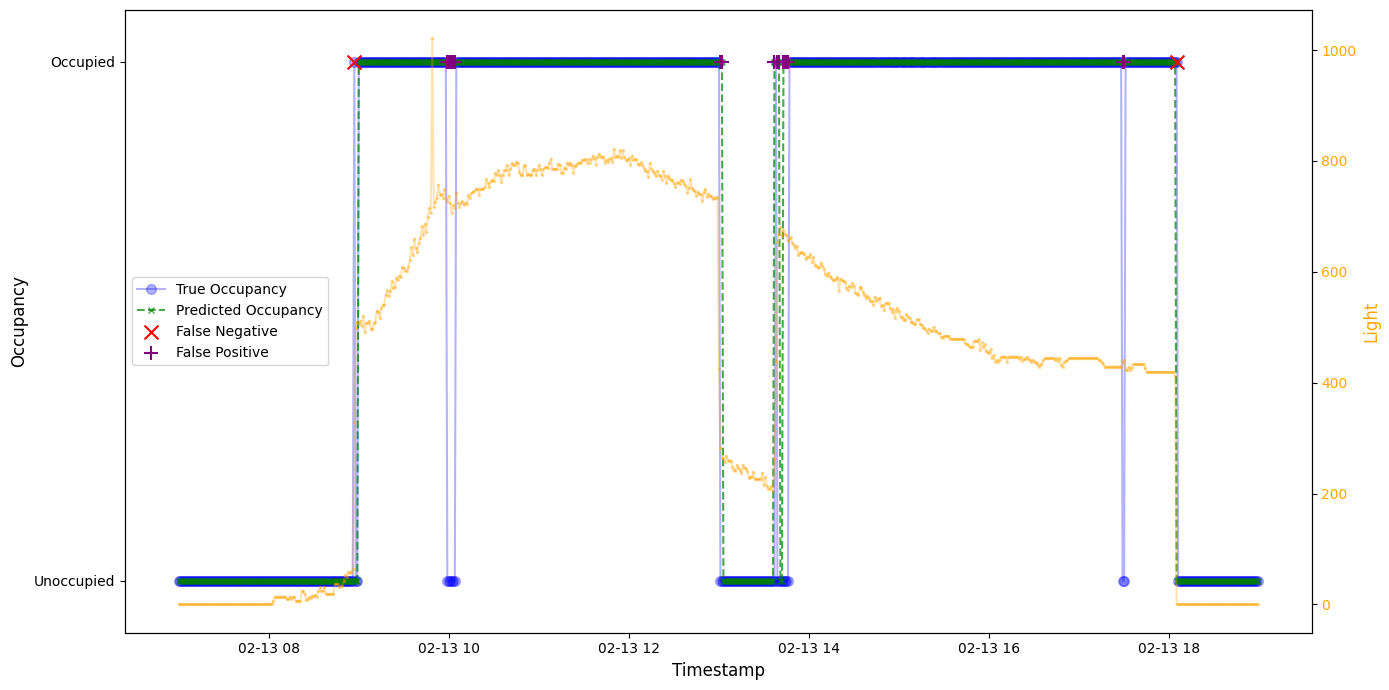

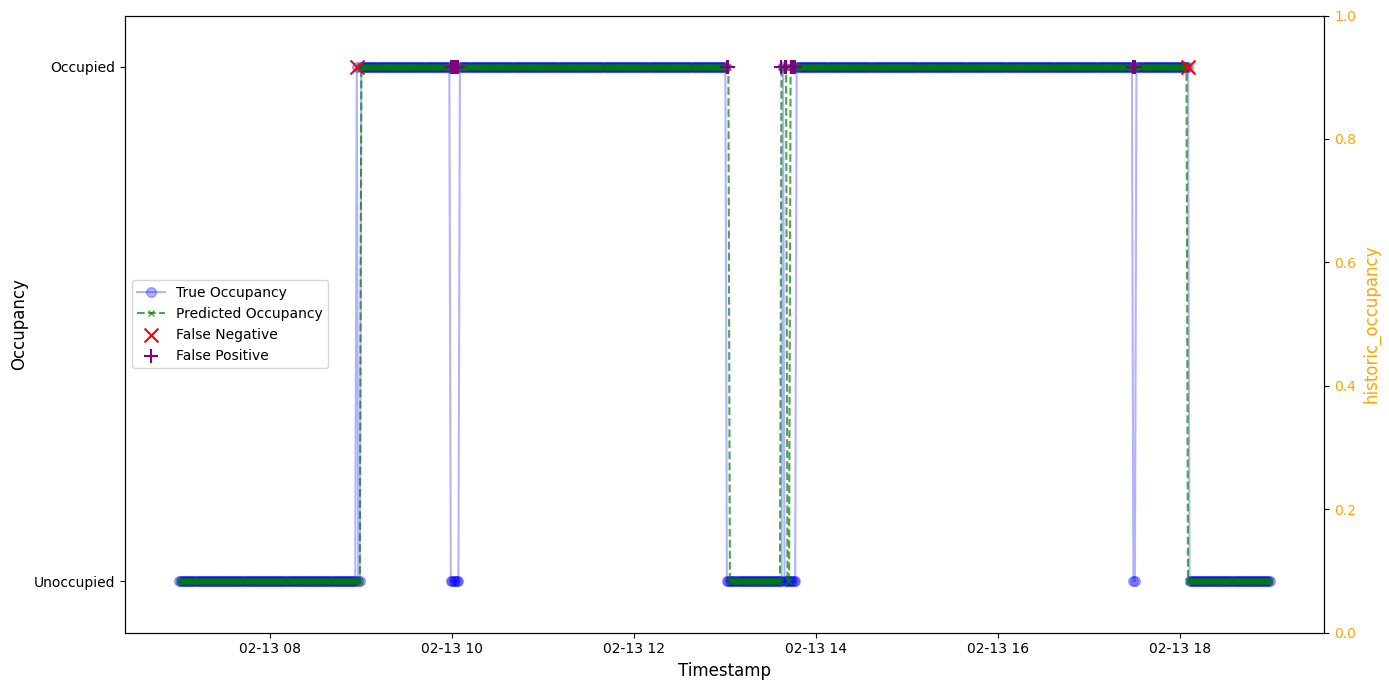

Date: 2015-02-16 / Day (07–19), Monday: 11 errors out of 720 records (1.53%)


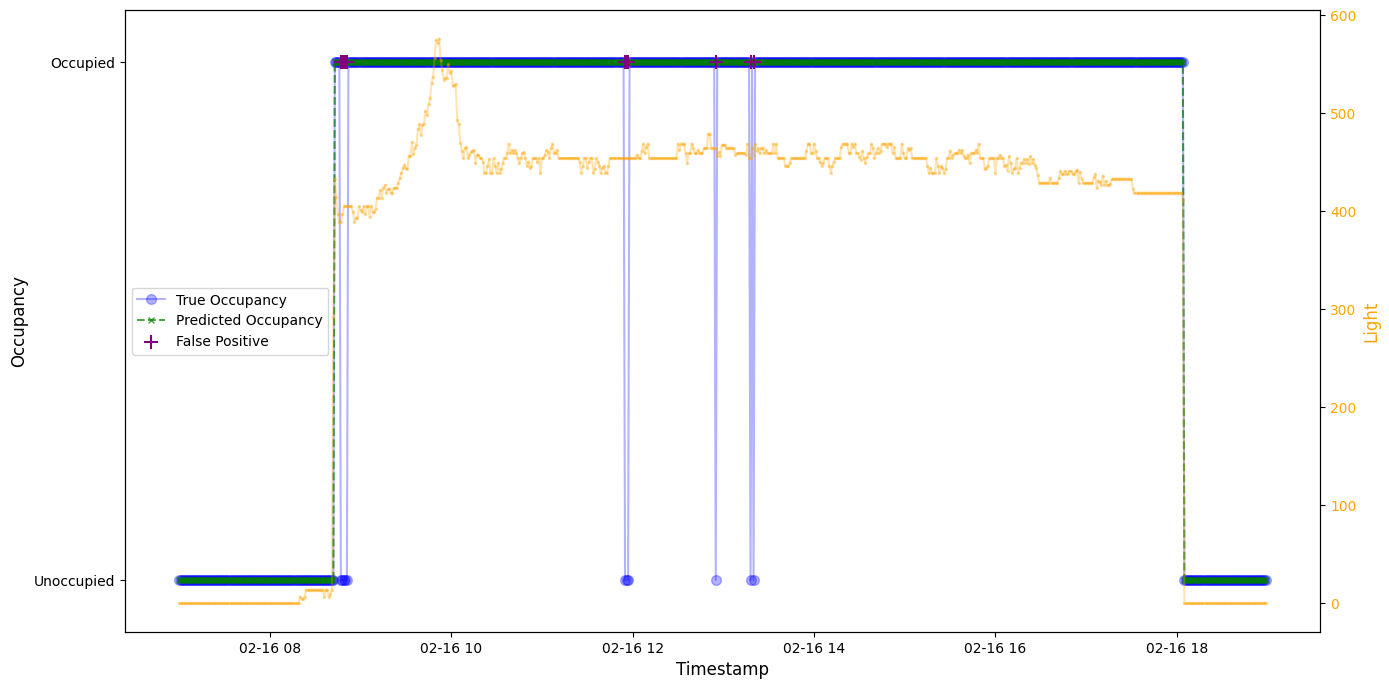

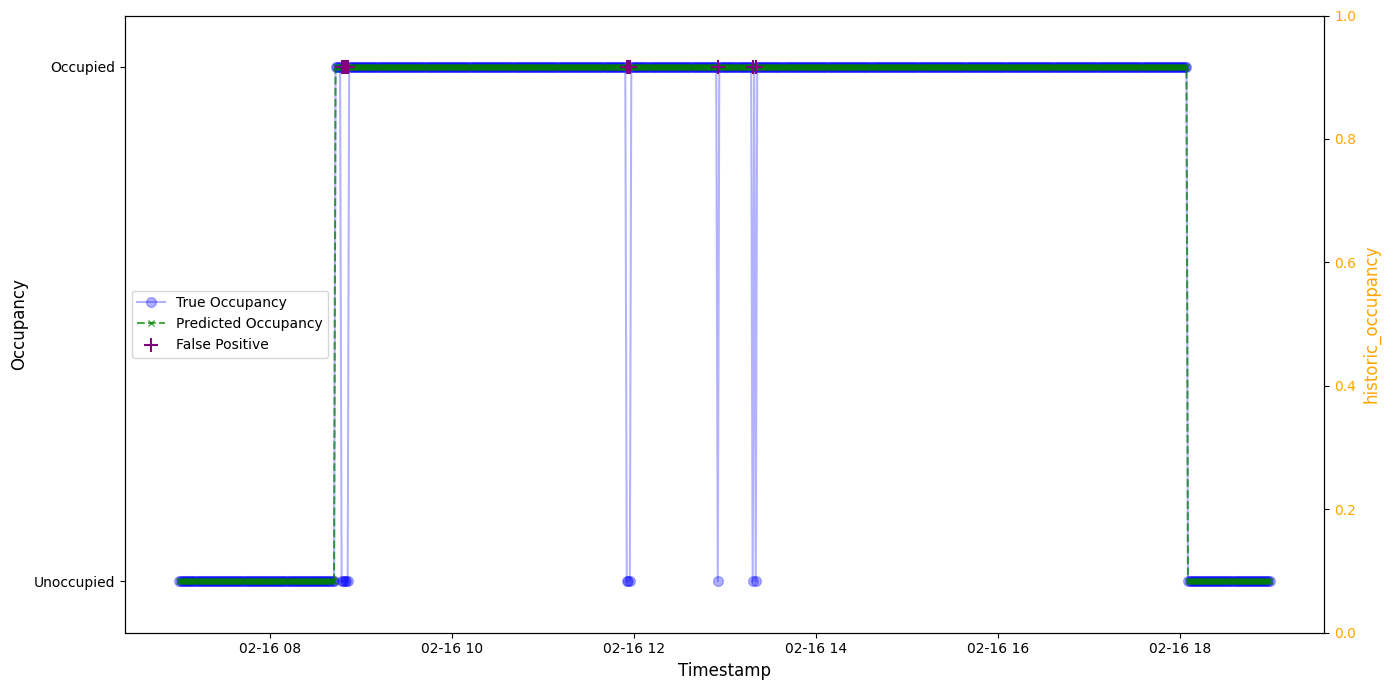

Date: 2015-02-17 / Day (07–19), Tuesday: 8 errors out of 720 records (1.11%)


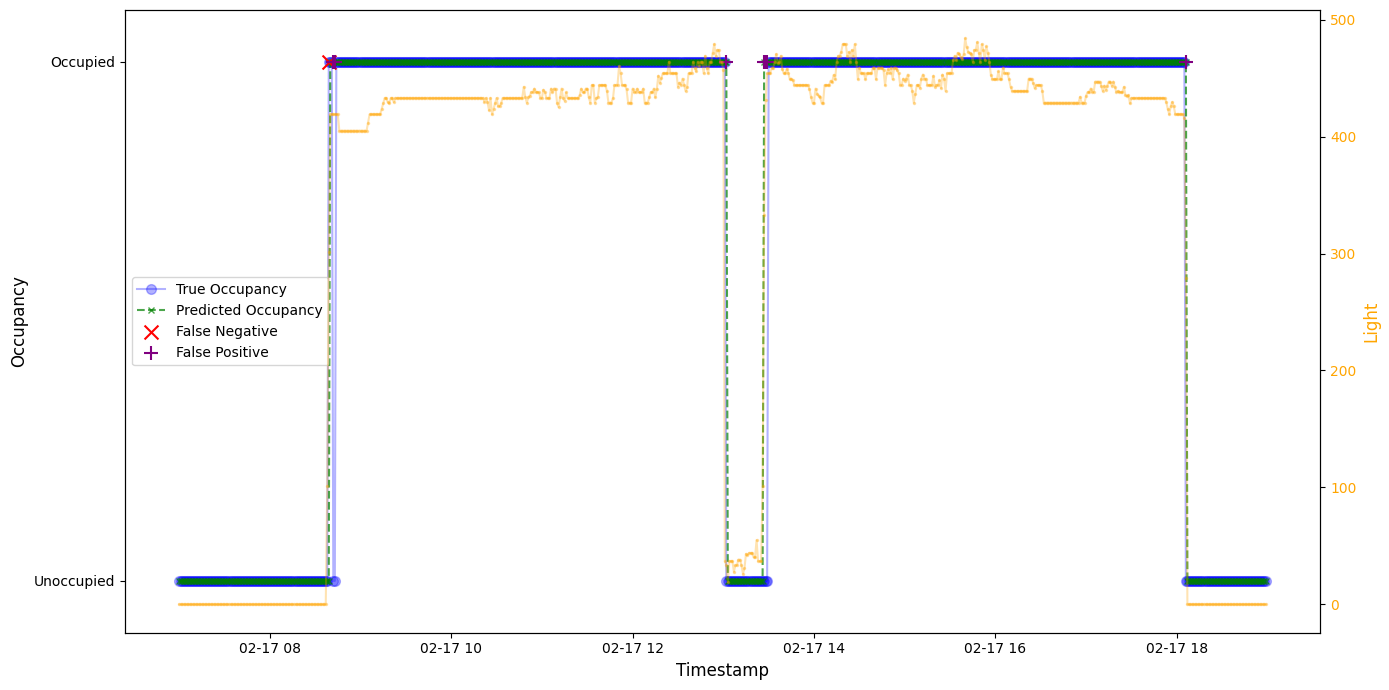

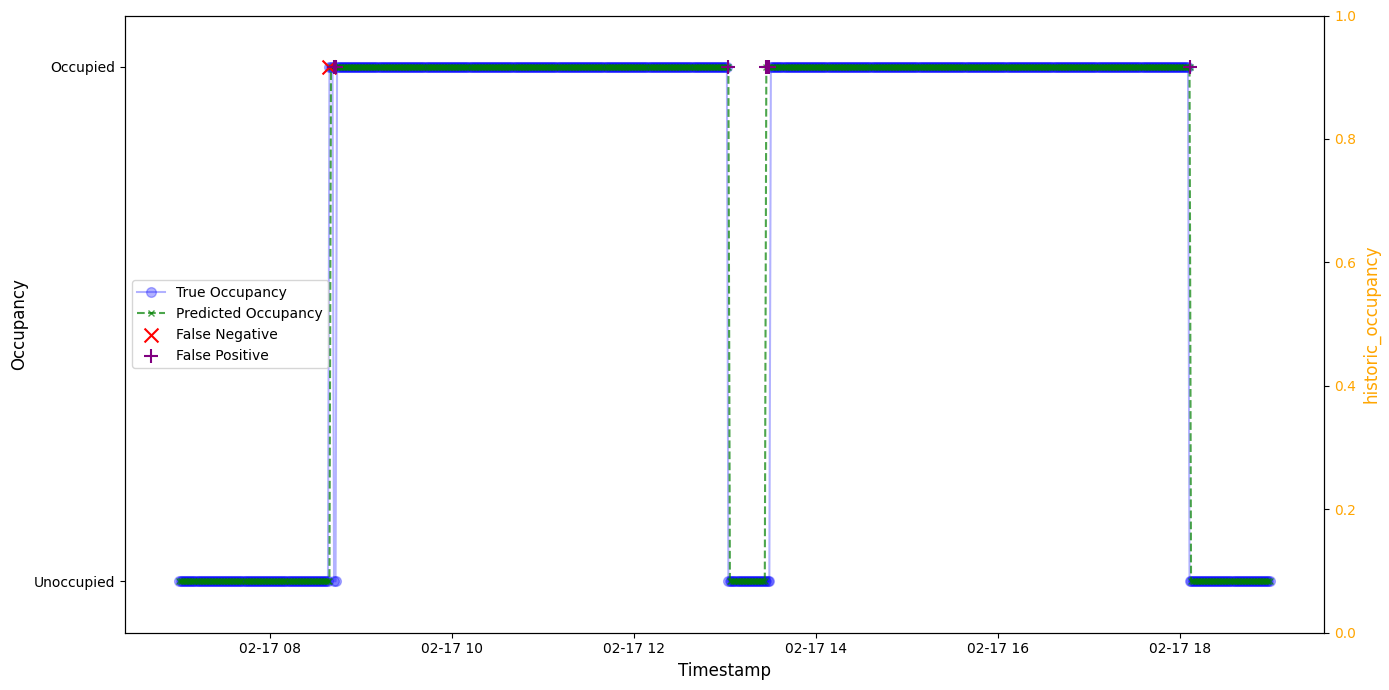


--- Test Set Misclassifications ---
Found classification errors on 4 days.
Date: 2015-02-02 / Day (07–19), Monday: 23 errors out of 281 records (8.19%)


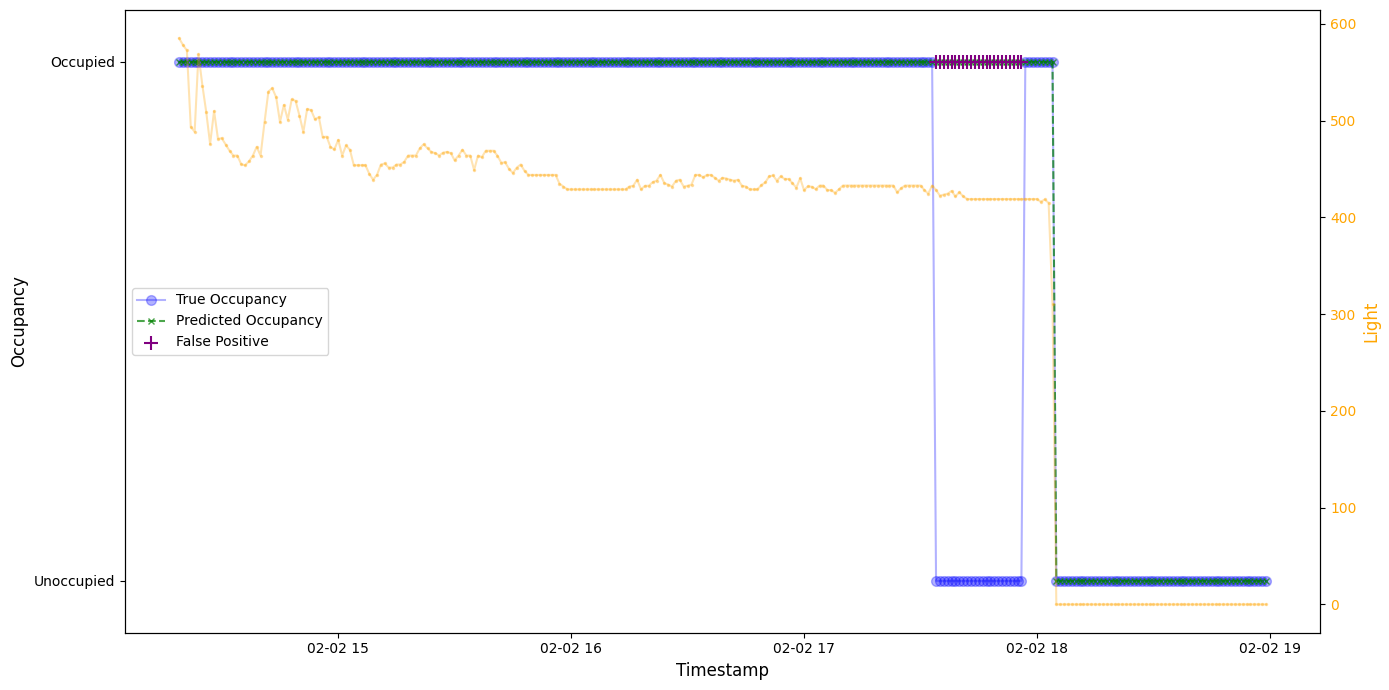

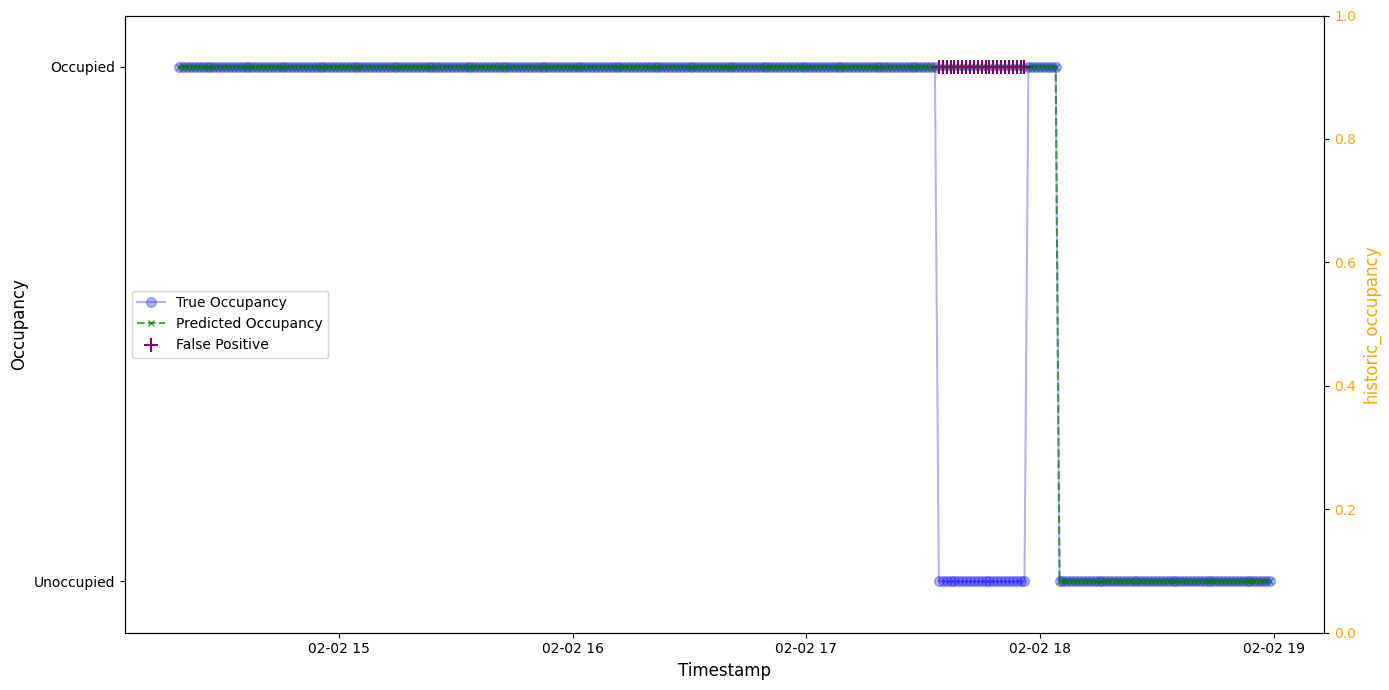

Date: 2015-02-03 / Day (07–19), Tuesday: 25 errors out of 720 records (3.47%)


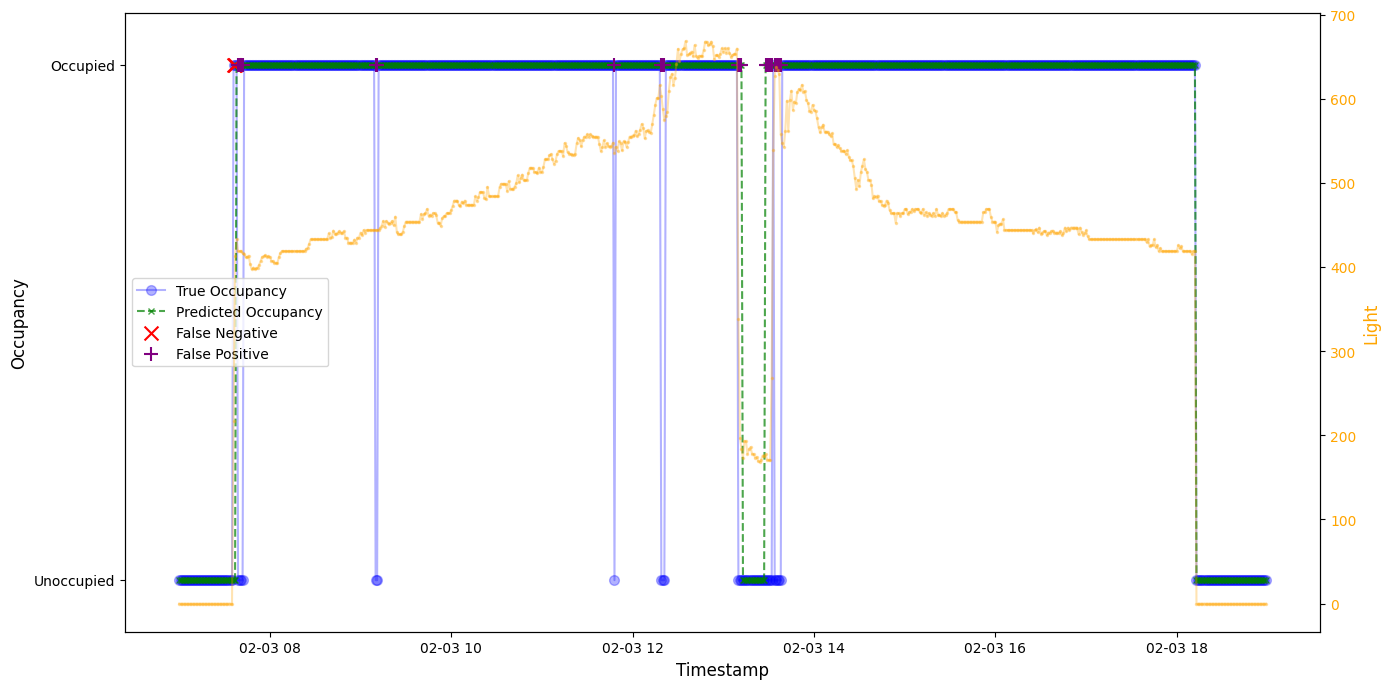

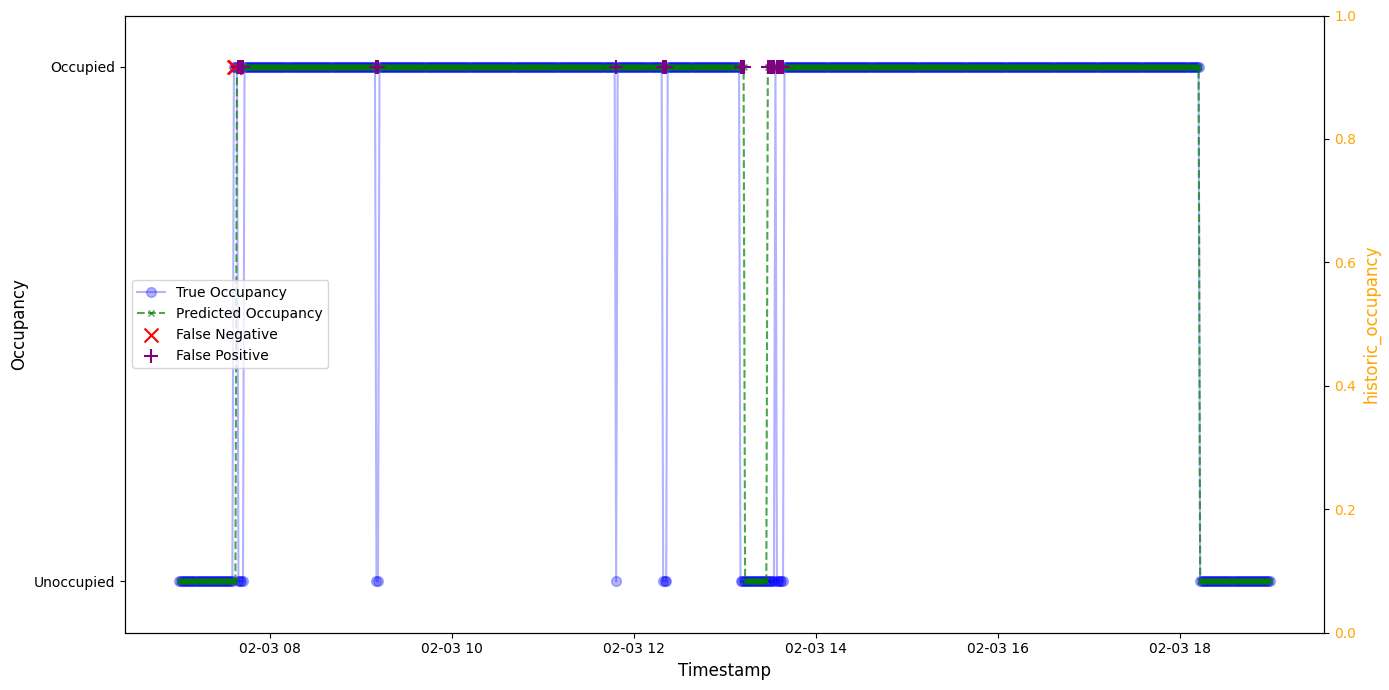

Date: 2015-02-05 / Day (07–19), Thursday: 66 errors out of 720 records (9.17%)


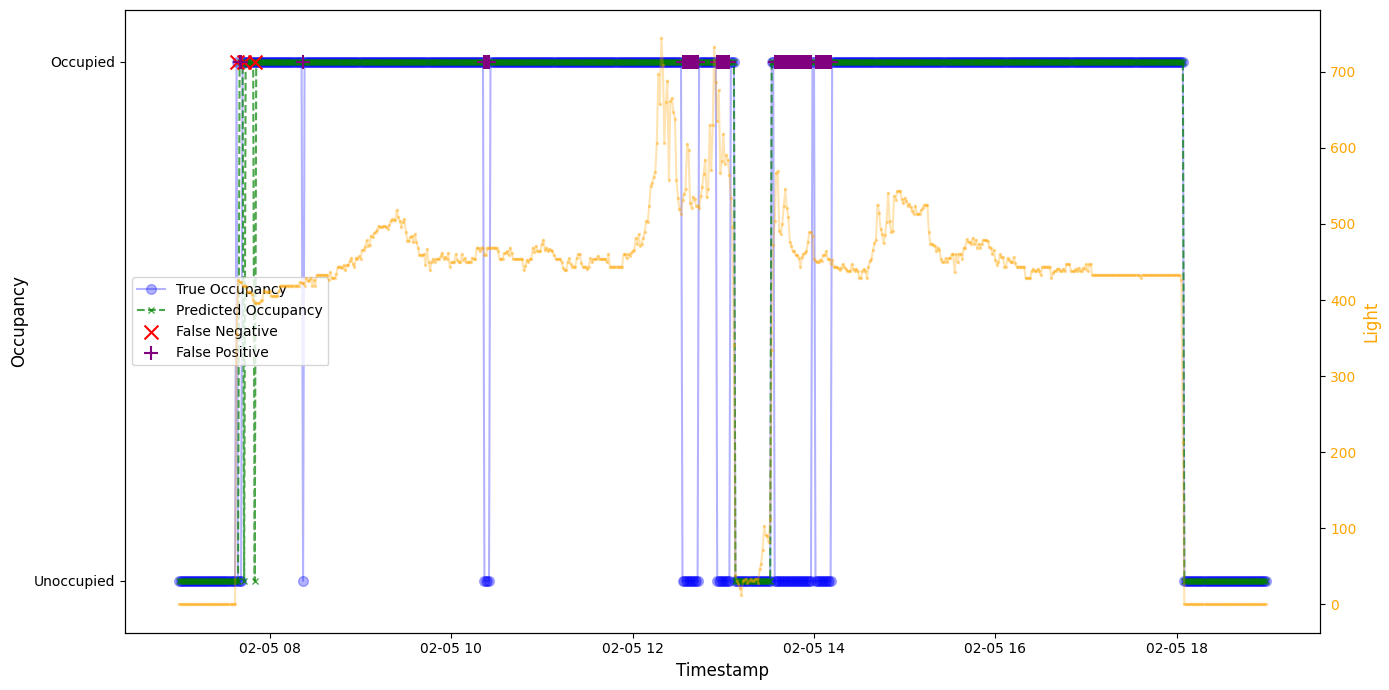

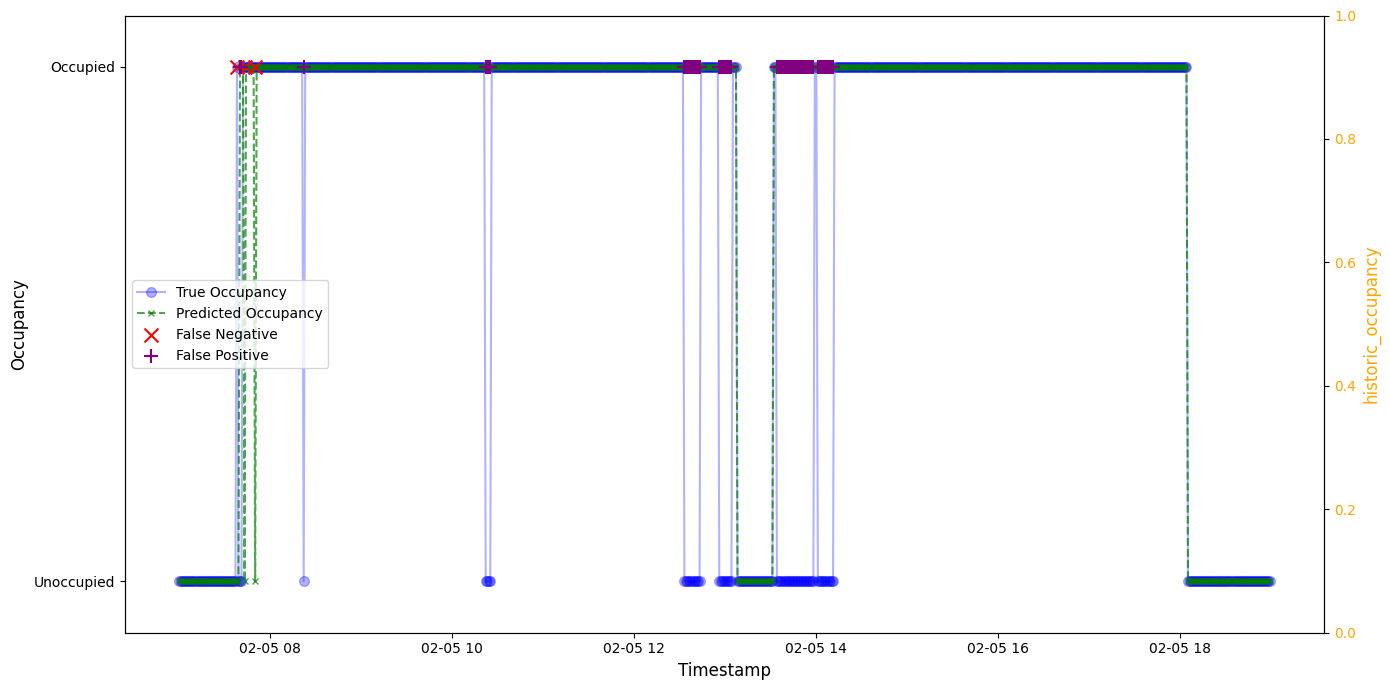

Date: 2015-02-15 / Day (07–19), Sunday: 68 errors out of 720 records (9.44%)


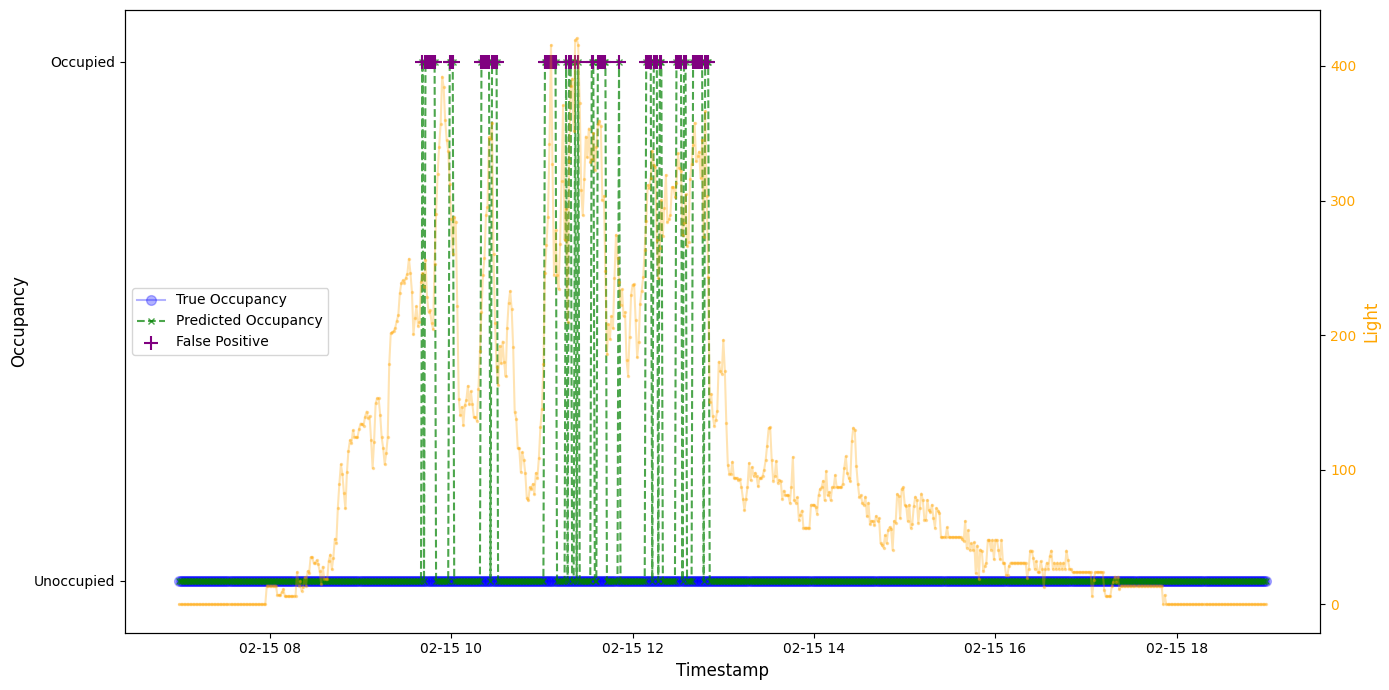

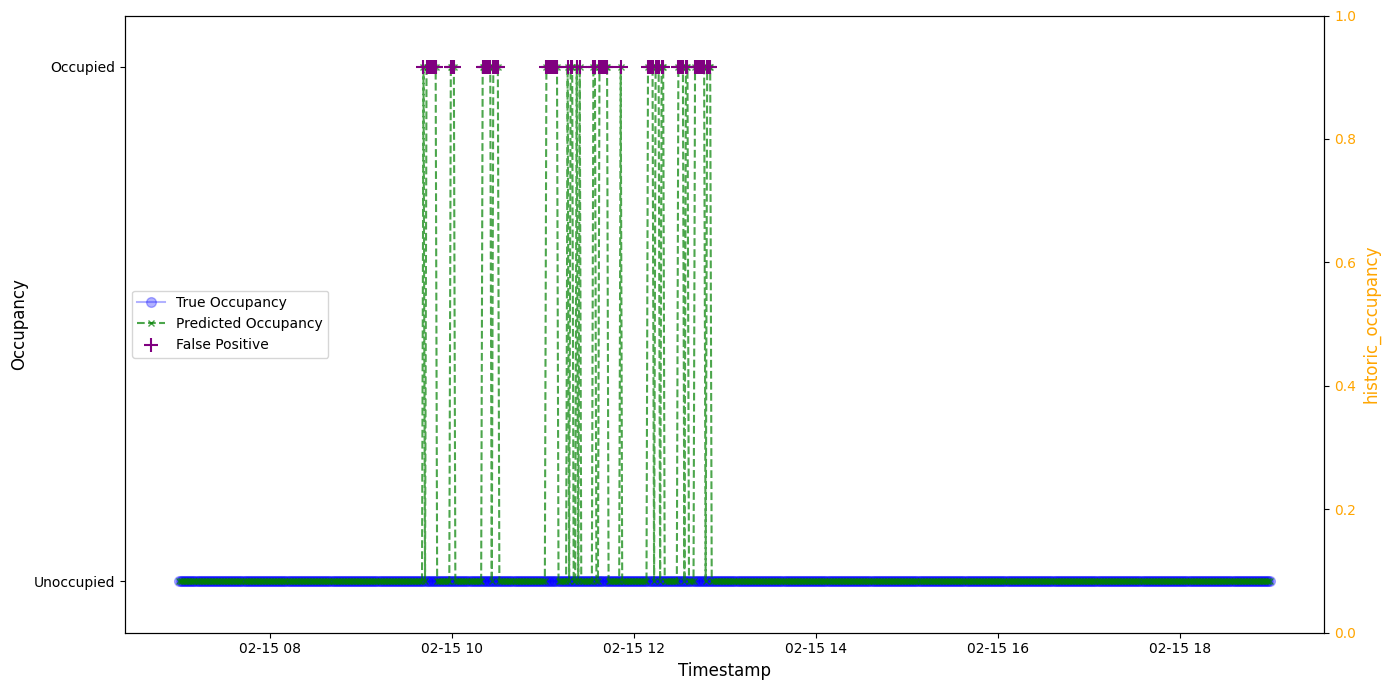

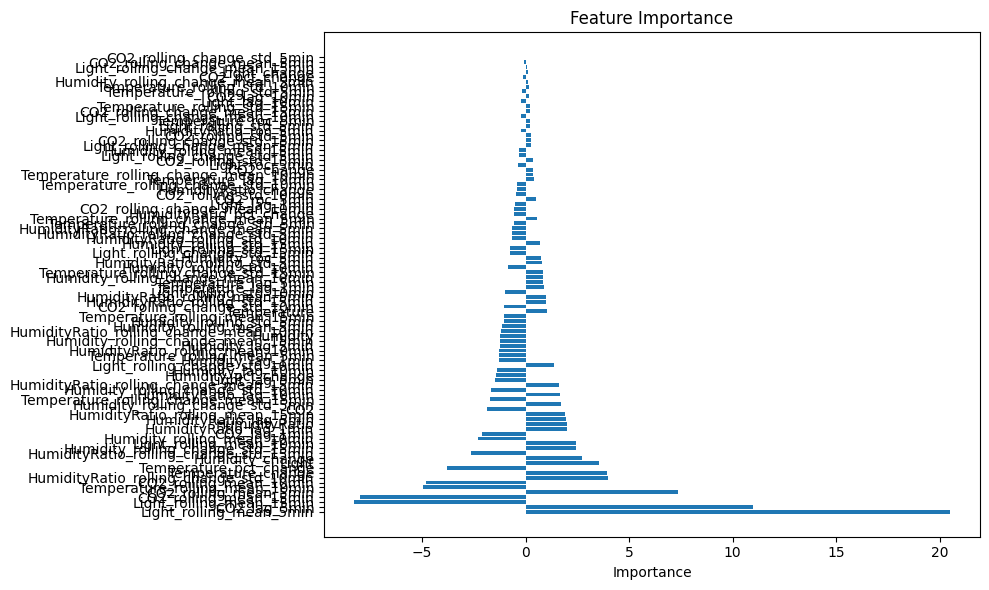

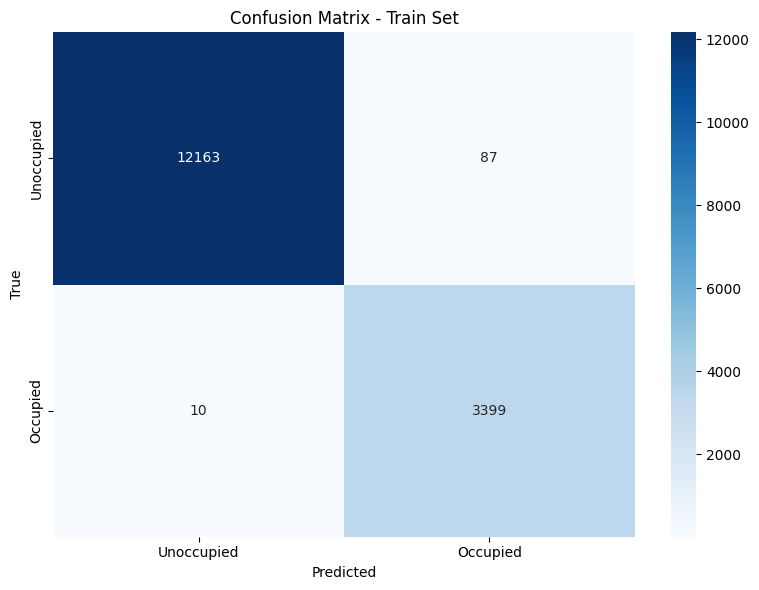

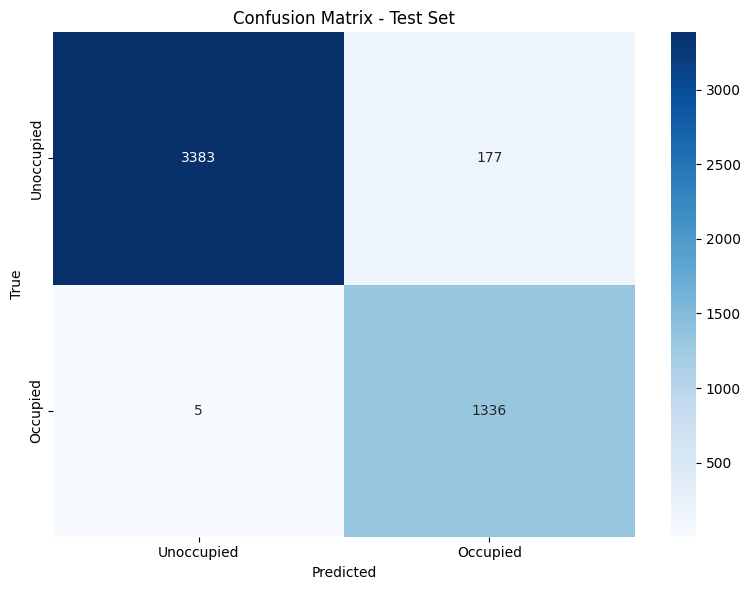

In [8]:
linear_eval_results = evaluate_and_visualize_model(best_linear_pipeline, X_train, y_train, X_val, y_val, train_idx=X_train.index, test_idx=X_val.index,
                            features_df=df, features_to_plot=['Light', 'historic_occupancy'])

Error processing parameter 'feature_selector__feature_selection': Encoders require their input argument must be uniformly strings or numbers. Got ['list']


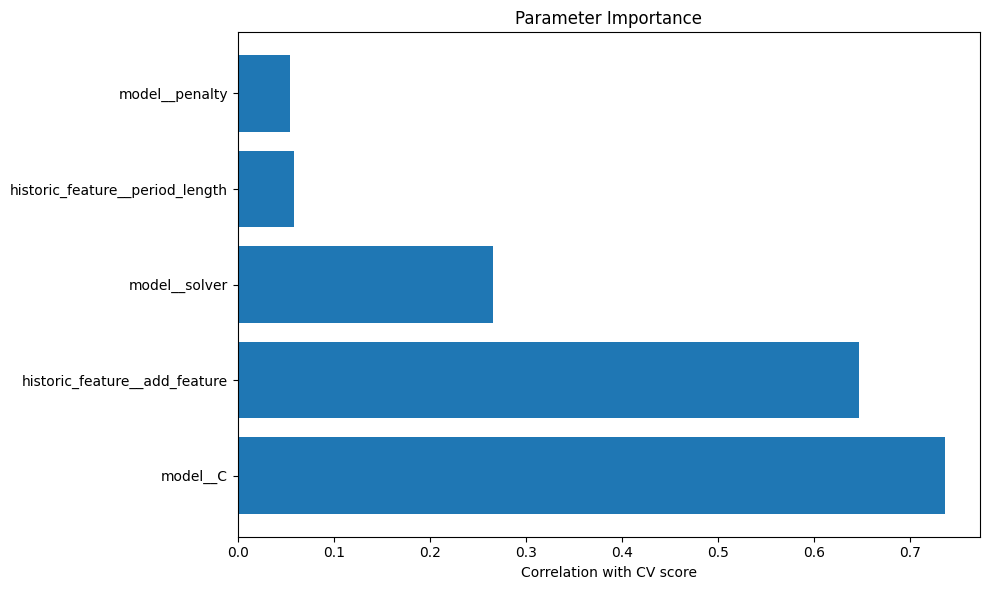

In [9]:
plot_param_importances(linear_cv_results)

In [10]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

sorted_df = pd.DataFrame(linear_cv_results).sort_values(by='rank_test_score', ascending=True)

display(sorted_df)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__solver,param_model__random_state,param_model__penalty,param_model__max_iter,param_model__class_weight,param_model__C,param_historic_feature__period_length,param_historic_feature__add_feature,param_feature_selector__feature_selection,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
1,3.517019,0.363187,0.098638,0.028412,liblinear,42,l2,4000,balanced,100.00,5,False,"[Temperature, Humidity, Light, CO2, HumidityRa...","{'model__solver': 'liblinear', 'model__random_...",0.989626,0.956072,0.931576,0.990491,0.974450,0.968443,0.022285,1,0.982516,0.986359,0.989593,0.981546,0.981186,0.984240,0.003247
3,0.156026,0.037233,0.081172,0.039715,liblinear,42,l2,4000,balanced,10.00,5,False,"[HumidityRatio, Light]","{'model__solver': 'liblinear', 'model__random_...",0.988724,0.983000,0.889515,0.989354,0.982143,0.966547,0.038626,2,0.947996,0.959963,0.968866,0.940887,0.944215,0.952385,0.010462
9,0.455584,0.128860,0.072756,0.041421,liblinear,42,l1,4000,balanced,100.00,60,False,"[HumidityRatio, Light, CO2]","{'model__solver': 'liblinear', 'model__random_...",0.989170,0.966422,0.890017,0.989730,0.983655,0.963799,0.037845,3,0.965618,0.968801,0.987706,0.962861,0.951327,0.967263,0.011801
8,1.019947,0.050872,0.117330,0.036759,liblinear,42,l2,4000,balanced,0.10,60,True,"[Temperature, Humidity, Light, CO2, HumidityRa...","{'model__solver': 'liblinear', 'model__random_...",0.967372,0.979405,0.842330,0.988593,0.982703,0.952081,0.055311,4,0.971899,0.977092,0.984534,0.968577,0.964316,0.973284,0.007008
6,0.677804,0.121382,0.176920,0.055477,saga,42,l2,4000,balanced,10.00,30,True,"[HumidityRatio, Light, CO2]","{'model__solver': 'saga', 'model__random_state...",0.990063,0.949193,0.842386,0.990099,0.980637,0.950476,0.056093,5,0.960617,0.963235,0.986969,0.956938,0.949489,0.963450,0.012637
0,0.240394,0.014598,0.137260,0.012882,liblinear,42,l2,4000,balanced,10.00,15,True,"[HumidityRatio, Light, CO2]","{'model__solver': 'liblinear', 'model__random_...",0.990511,0.952082,0.833070,0.990854,0.980322,0.949368,0.059841,6,0.958585,0.960605,0.987524,0.955631,0.946065,0.961682,0.013850
5,0.577134,0.056694,0.288661,0.040522,liblinear,42,l1,4000,balanced,10.00,5,True,"[HumidityRatio, Light]","{'model__solver': 'liblinear', 'model__random_...",0.990958,0.953725,0.821391,0.990847,0.978812,0.947147,0.064327,7,0.961803,0.964310,0.987710,0.958029,0.948675,0.964106,0.012942
7,27.695325,8.278094,0.116979,0.022187,saga,42,l1,4000,balanced,0.01,15,True,"[Temperature, Humidity, Light, CO2, HumidityRa...","{'model__solver': 'saga', 'model__random_state...",0.982960,0.960434,0.806320,0.991609,0.986486,0.945562,0.070432,8,0.942308,0.940965,0.980252,0.939570,0.924112,0.945441,0.018607
4,0.364207,0.011051,0.265682,0.043014,liblinear,42,l2,4000,balanced,10.00,5,True,"[HumidityRatio, Light]","{'model__solver': 'liblinear', 'model__random_...",0.990958,0.947119,0.812950,0.991231,0.976369,0.943725,0.067331,9,0.959417,0.957856,0.987524,0.956086,0.946355,0.961448,0.013810
2,0.137170,0.031985,0.059015,0.027606,liblinear,42,l2,4000,balanced,0.10,30,False,"[HumidityRatio, Light, CO2]","{'model__solver': 'liblinear', 'model__random_...",0.935608,0.976797,0.859477,0.961595,0.977373,0.942170,0.044038,10,0.929736,0.921087,0.962827,0.903627,0.901807,0.923817,0.022164
